In [4]:
import os
from os.path import exists, join, basename, dirname

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\ajcalder/Box/research_cosumnes/GWFlowModel'

In [7]:
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')
nrow,ncol = dem_data.shape

In [ ]:
# Pre-cretaceous metamorphic rocks - (variable thickness 200-500 ft thick)
# Ione formation (200 ft thick)
# Valley Springs formation (300 ft thick)
# Mehrten Formation (100 ft thick to 300 ft thick) (1-2 deg dip)
# Laguna Formation (less than 100 ft to between 200-300 ft thick) (less than 1 deg dip)
# upper formation (informed by well logs) (100 ft)
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell


The stream gage at michigan bar is now 13 columns in from the boundary mehrtenbound
adjusted input from 36 to 38 ( to account for extra 2600 m ~2miles) in Sept 2020

The actual DWR cross-section extends from 38 miles to 19 miles in the east cross-section and from 19 to 0 miles in the west cross-section. The 52.9 degree 100 row, 230 column model domain starts at the 38 mile mark, while cross-section E-E' has an angle of approximately 21.95 degrees; XS E-E' and F-F' have roughly the same angle. The primary difference between cross-section E (north) and F(south) is the magnitude of depth of the Laguna-Mehrten boundary, 250 ft (E) vs 450 ft (F) at the 20 mile mark



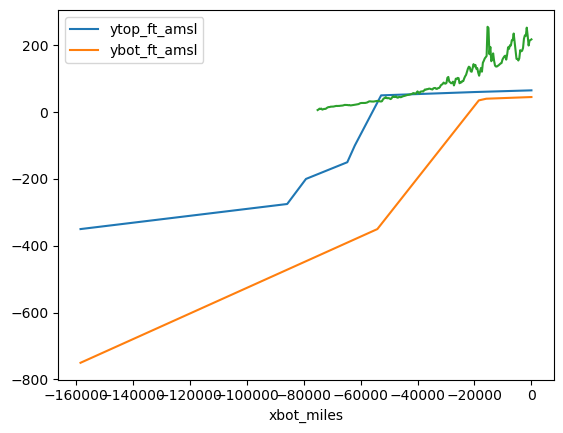

In [9]:
# # columns are xtop_miles, ytop_ft_amsl, xbot_miles, ytop_ft_amsl
# # XS upper bound should be at Michigan bar which is between Jackson road and Sacramento-Amador county line split
# # Mile 36 is approximately where Michigan bar aligns with the cross section
MB_XS_mile = 36
mehrtenbound = pd.read_csv(gwfm_dir+'/DIS_data/Mehrten_boundary_x_y.csv', parse_dates = False, 
                index_col = False, sep = ',', header = 'infer')
# Convert miles to feet and sets x value based on location of Michigan bar
# 0 is michigan bar and each major change in geologic dip is based on distance from Michigan Bar
mehrtenbound.xtop_miles = -5280*(MB_XS_mile - mehrtenbound.xtop_miles)
mehrtenbound.xbot_miles = -5280*(MB_XS_mile - mehrtenbound.xbot_miles)
# No flod boundary based on the original coordinates of the bottom of the Mehrten formation
mehrtenbound.noflow_x_miles = -5280*(MB_XS_mile - mehrtenbound.noflow_x_miles)

# East of mile 32 the entire vertical cross section, including up to the near entire surface
# is composed of old geologic formations that are not water bearing
volcanic_bound = (MB_XS_mile - 32)*-5280
# noflow_ind = int((1-(volcanic_bound/sumx))*ncol)

# Plot the x and y values
fig, ax = plt.subplots(1, 1)
mehrtenbound.plot(x = 'xtop_miles', y = 'ytop_ft_amsl', ax = ax)
mehrtenbound.plot(x = 'xbot_miles', y = 'ybot_ft_amsl', ax = ax)
plt.plot(-100*3.28*np.arange(0,len(dem_data[40,:])), np.flip(3.28*dem_data[40,:]))
# print(mehrtenbound)

In [10]:

def xy_to_botm(xbound_ft, ybound_ft, nspace,ntransversespace):
    laybotm = np.zeros((ntransversespace, nspace))
    # Nspace will be either nrow or ncol depending model direction
    # ntransversespace is the opposite of nspace (ie nrow if nspace is ncol)
    # Calculate the distance between each major change in dip
    dx = np.diff(xbound_ft)
    # Scale by the total distance across the coordinates to get percentages
    sumx = np.sum(dx)
    dx /= sumx
    # Multiply the number of columns by the percent of columns in each section of constant dip
    dx *= nspace
    # Round the number of columns to allow proper use for indexing
    nx = np.round(dx).astype(int)
    # Fix any discrepancy in number of columns due to issues with rouding the percentages of columns
    # Add a column to the last set of columns because there is already uncertainty at the deeper end
    while(np.sum(nx)-nspace !=0):
        if np.sum(nx)-nspace <0:
            nx[-1] += 1
        elif np.sum(nx)-nspace >0:
            nx[-1] -= 1
    sum(nx)

    # Now split the coordinates into downsized coordinates in between each major change in dip
    k = 0
    for i in np.arange(0,len(nx)):
        for j in np.arange(0,ntransversespace):
            laybotm[j, k:k+nx[i]] = np.arange(ybound_ft[i],ybound_ft[i+1], -(ybound_ft[i]-ybound_ft[i+1])/nx[i])
        k += nx[i]
    return(laybotm)

In [11]:
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation top boundary

mehrten_top = xy_to_botm(mehrtenbound.xtop_miles,mehrtenbound.ytop_ft_amsl, ncol, nrow)
# X (east -west) and y (up-down vertical) of major dip changes for Mehrten Formation bottom boundary
# drop na is because there are less values to mark changes in the bottom than top boundary
mehrten_bottom = xy_to_botm(mehrtenbound.xbot_miles.dropna(),mehrtenbound.ybot_ft_amsl.dropna(), ncol, nrow)

# Original x,y data for Mehrten bottom boundary to represent the noflow bounds
no_flow_bound = xy_to_botm(mehrtenbound.noflow_x_miles.dropna(), mehrtenbound.noflow_y_ft_amsl.dropna(),ncol,nrow)

In [12]:
nlay = 3
botm = np.zeros((nlay, nrow, ncol))
# Convert units from ft to meters and flip to match direction
botm[-2,:,:] = np.flip(mehrten_top/3.28)
botm[-1,:,:] = np.flip(mehrten_bottom/3.28)
no_flow_bound = np.flip(no_flow_bound/3.28)



In [14]:
bas_dir = join(gwfm_dir, 'BAS6')

np.savetxt(join(bas_dir, 'mehrten_top.txt'), botm[-2])
np.savetxt(join(bas_dir, 'mehrten_bottom.txt'), botm[-1])
np.savetxt(join(bas_dir, 'no_flow_boundary.txt'), no_flow_bound)